In [1]:
import numpy as np
import matplotlib.pyplot as plt

from transformer import TimeSeriesTransformer
from inference import inference
from trainer import train_model
from dataset import CustomDataset, BatchSampler
from psd import power_spectrum_error, get_average_spectrum

In [2]:
input_dim = 3
d_model = 16
nhead = 16
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 64
dropout = 0.1
output_dim = 3
input_length = 200
output_length = 10
batch_size = 512
num_epochs = 5000


train_data = np.load('./data/lorenz63_on0.05_train.npy')
dataset = CustomDataset(train_data, input_length=input_length, output_length=output_length)
data_loader = BatchSampler(dataset, batch_size)

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
loss = train_model(model, data_loader, num_epochs, d_model)

Epochs: 100%|██████████| 5000/5000 [30:44<00:00,  2.71it/s, Loss=0.002891]


In [3]:
test_data = np.load('./data/lorenz63_test.npy')
output_steps = 500
dataset = CustomDataset(test_data, input_length=input_length, output_length=output_steps)
data_loader = BatchSampler(dataset, 1000)
x, y = data_loader()
test = np.load('./data/lorenz63_test.npy')
pred = inference(model, x, input_length=input_length, output_length=output_length, output_steps=output_steps)

Text(0, 0.5, 'mse')

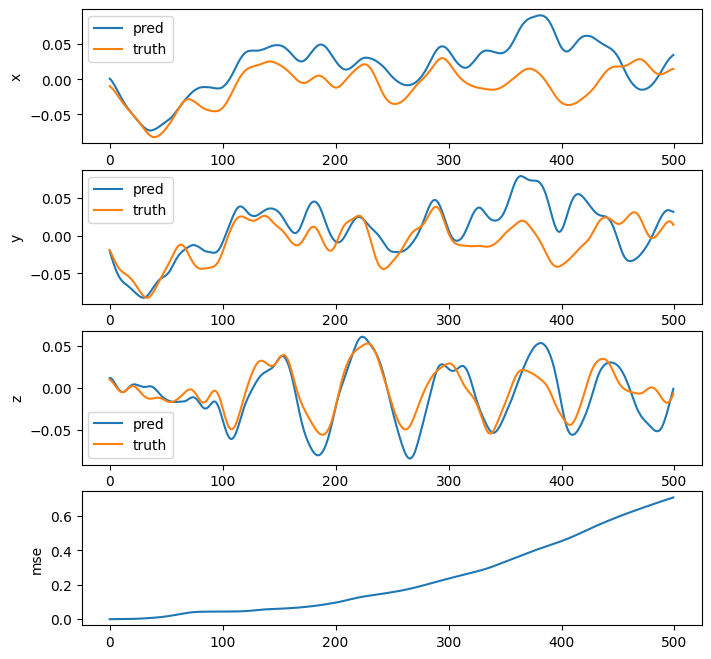

In [28]:
fig, axes = plt.subplots(4, figsize=(8,8))
ylabel = ['x', 'y', 'z']
for i in range(3):
    axes[i].plot(pred[:, input_length:, i].mean(0), label='pred')
    axes[i].plot(y[:, 1:, i].mean(0), label='truth')
    axes[i].set_ylabel(ylabel[i])
    axes[i].legend()

se = ((pred[:, input_length:]-y[:, 1:].numpy()) ** 2).mean(0)
mse = [se[:j].mean() for j in range(1, output_steps+1)]
axes[3].plot(mse)
axes[3].set_ylabel("mse")

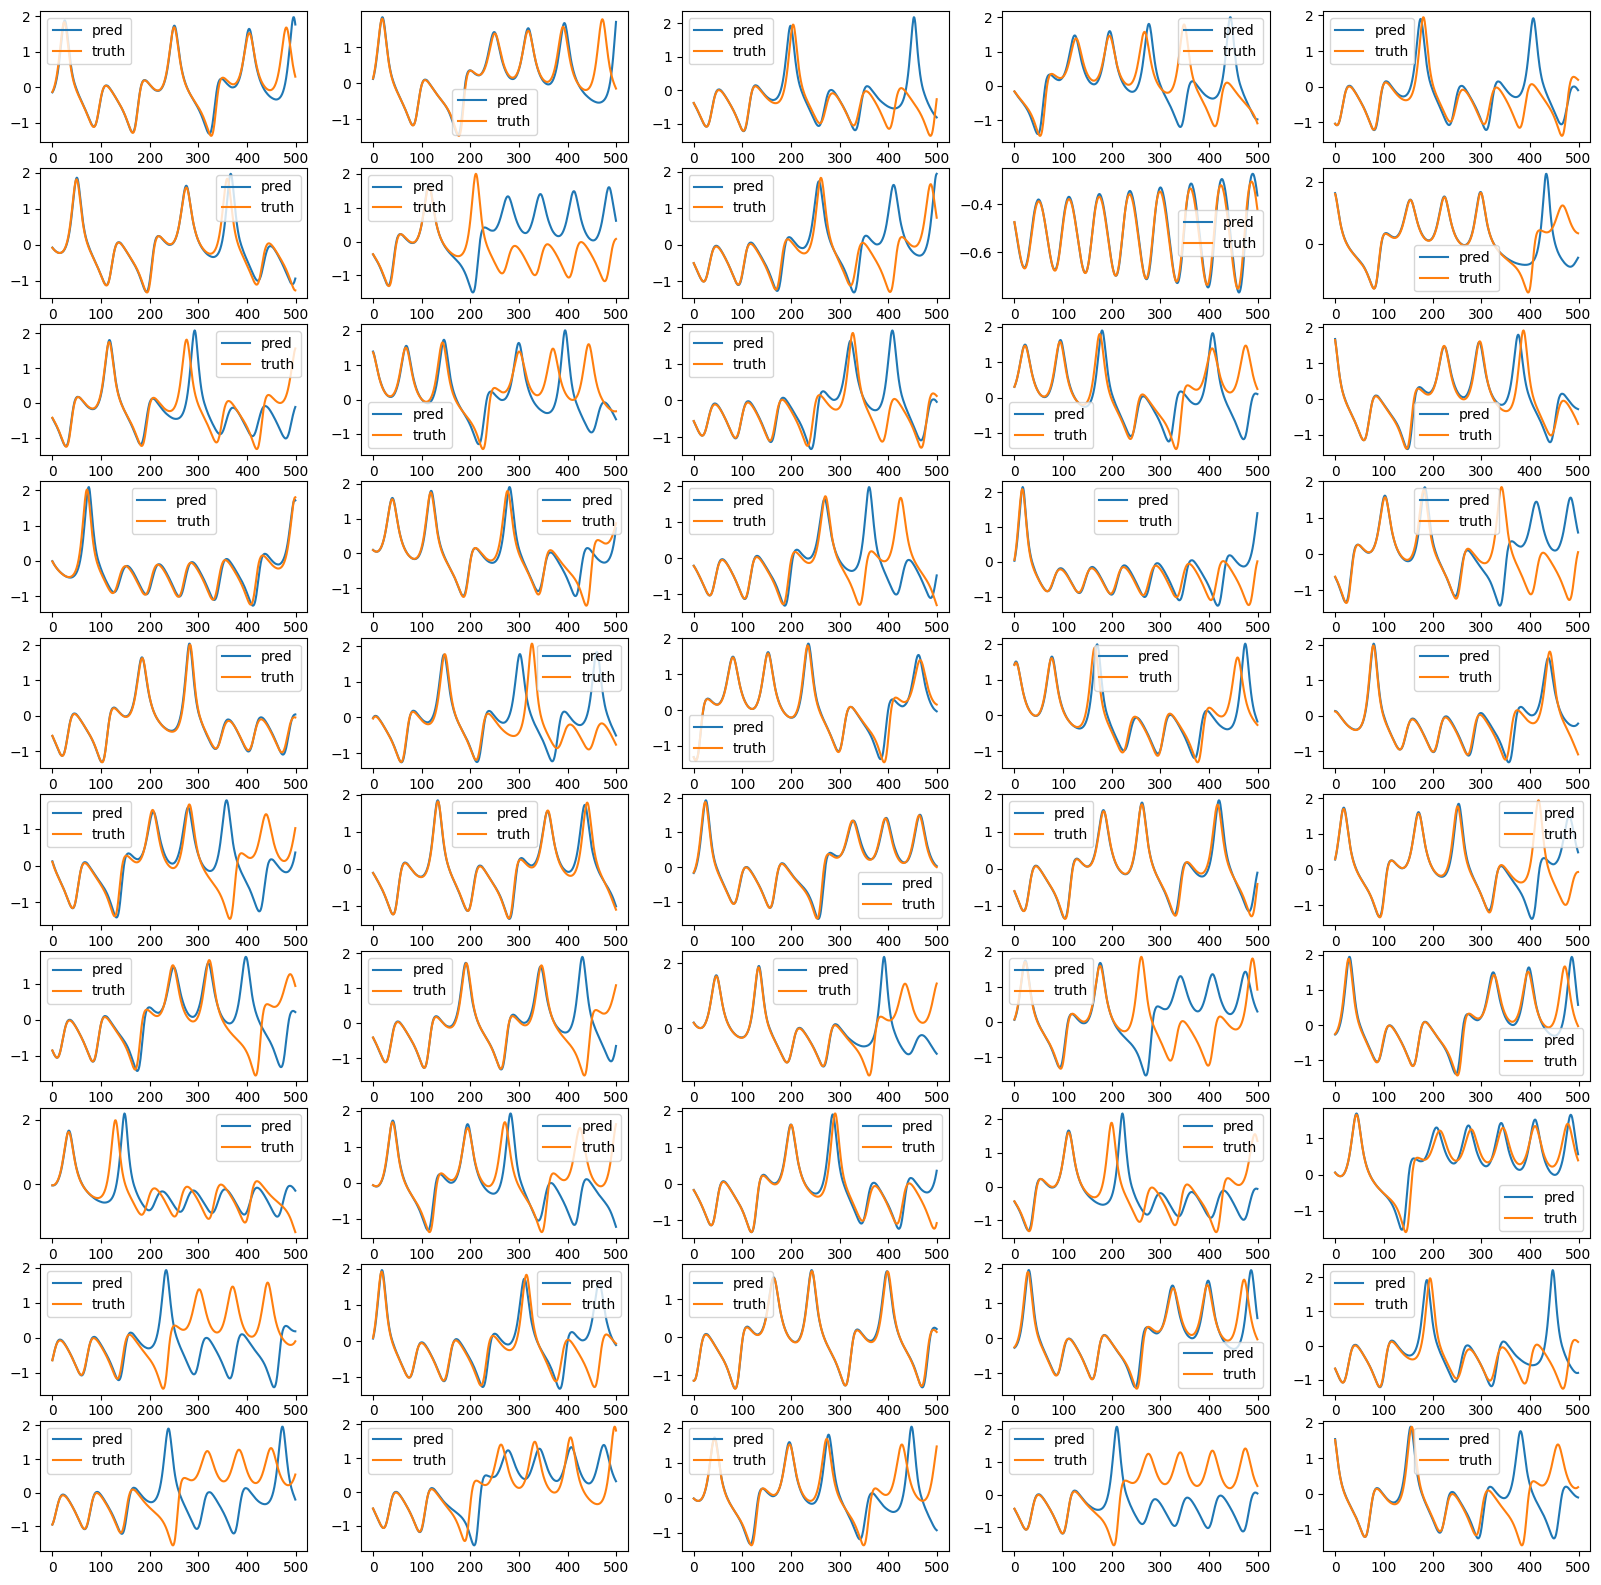

In [40]:
fig, axes = plt.subplots(10, 5, figsize=(20, 20))
for i in range(5):
    for j in range(10):
        idx = np.random.randint(1000)
        axes[j, i].plot(pred[idx, input_length:].mean(1), label='pred')
        axes[j, i].plot(y[idx, 1:].mean(1), label='truth')
        axes[j, i].legend()
plt.show()

Text(0.5, 1.0, 'Powerspectra')

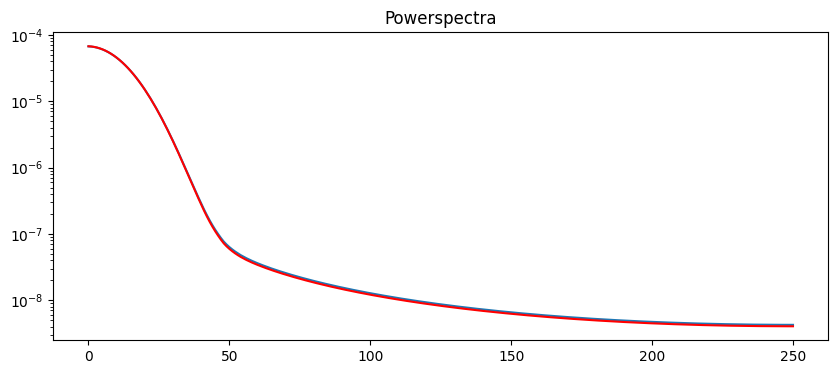

In [72]:
fig, axes = plt.subplots(1, figsize=(10, 4))
axes.plot(np.array([get_average_spectrum(pred[:, input_length:, dim], 10) for dim in range(3)]).mean(0).mean(0), label="Generated")
axes.plot(np.array([get_average_spectrum(y[:, 1:, dim], 10) for dim in range(3)]).mean(0).mean(0), color='red',  label="Ground Truth")
axes.set_yscale("log")
axes.set_title('Powerspectra')

In [62]:
power_spectrum_error(pred[:, input_length:], y[:, 1:].numpy(), 80)

np.float64(0.03745925231191011)